In [1]:
import sys
sys.path.append("..")
import itertools
from pathlib import Path
import pickle
from datetime import date

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import talib

from btc_predictor.datasets import DataReader

mpl.rcParams['figure.figsize'] = [16.0, 9.0]
%matplotlib inline
%load_ext autoreload
%autoreload 2
tf.random.set_seed(78)

In [2]:
data = DataReader(data_file="../btc_predictor/datasets/Bitstamp_BTCUSD_d.csv")
df = data.pd

In [3]:
BTCUSD = df.copy()

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)
print(f'Total daily data: {BTCUSD.shape[0]} days')

Total daily data days 1973


# 1. Univariate RNN Model

Our best statistical model is ARIMA(5, 1, 1) was trained using 330 days of closing log returns and forcasted on forward 7 days. To make models comparable, we will also try to forecast the forward 7 days log returns.

In [4]:
TRAIN_SIZE = 1680
VAL_SIZE = 180
time_series_data = BTCUSD['log_ret'].to_numpy()
train = time_series_data[:TRAIN_SIZE]
val = time_series_data[TRAIN_SIZE:VAL_SIZE]
test = time_series_data[VAL_SIZE:]

## 1.1 Data Preprocessing using tf.data

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


In [6]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(train, 0, 900,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(train, 900, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [7]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target price to predict')
print (y_train_uni[0])

Single window of past history
[[-0.00901267]
 [ 0.01343588]
 [ 0.00227021]
 [-0.00682615]
 [-0.03092432]
 [ 0.02634754]
 [ 0.00031999]
 [ 0.00478763]
 [-0.03307201]
 [-0.03949611]
 [-0.0067562 ]
 [ 0.00243864]
 [ 0.01563731]
 [-0.00858447]
 [-0.0036487 ]
 [ 0.        ]
 [-0.05926549]
 [-0.02740066]
 [-0.02820469]
 [ 0.01850347]
 [ 0.03701097]
 [-0.02094574]
 [ 0.02255056]
 [ 0.01492498]
 [-0.04060592]
 [-0.00857331]
 [ 0.03534285]
 [-0.04636172]
 [ 0.00233985]
 [-0.00585992]]

 Target price to predict
-0.009063120499774868


In [8]:
def create_time_steps(length):
    return list(range(-length, 0))


In [9]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
            label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

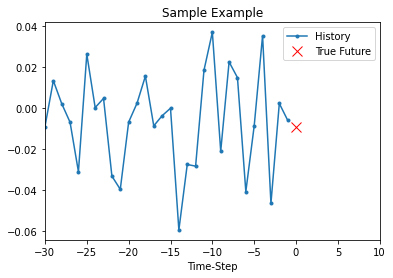

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

In [11]:
# Let's now use tf.data to shuffle, batch, and cache the dataset.

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


In [24]:
train_univariate.take(1)

<TakeDataset shapes: ((None, 30, 1), (None,)), types: (tf.float64, tf.float64)>

In [180]:
class Config:
    def __repr__(self):
        return str([(k, v) for k, v in config.__dict__.items() if k[:1] != '_'])

In [181]:
[(k, v) for k, v in config.__dict__.items() if k[:1] != '_']

[('window_size', 31)]

In [213]:
def create_data(data: np.ndarray, window_size=31, batch_size=15, shift_size=1, stride_size=1) -> tf.data.Dataset:
    data = tf.data.Dataset.from_tensor_slices(data.reshape(-1, 1))
    data = data.window(size=window_size, shift=shift_size, stride=stride_size, drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(window_size, drop_remainder=True))
    data = data.map(lambda window: (window[:-1], tf.reshape(window[-1:], []))).cache().batch(batch_size).repeat()
    return data

In [214]:
train_x = create_data(time_series_data)

In [215]:
train_x

<RepeatDataset shapes: ((None, 30, 1), (None,)), types: (tf.float64, tf.float64)>

In [128]:
# window_size = 31
# batch_size = 15
# shift_size = 1
# stride_size = 1
# train_x = tf.data.Dataset.from_tensor_slices(time_series_data.reshape(-1, 1))
# train_x = train_x.window(size=window_size, shift=shift_size, stride=stride_size, drop_remainder=True)
# train_x = train_x.flat_map(lambda window: window.batch(window_size, drop_remainder=True))
# train_x = train_x.map(lambda window: (window[:-1], tf.reshape(window[-1:], []))).cache().batch(BATCH_SIZE).repeat()


## 1.2 Simple RNN Model

In [101]:
x_train_uni.shape

(870, 30, 1)

In [102]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_uni.shape[-2:]),
    
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [103]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [216]:
EVALUATION_INTERVAL = 90
EPOCHS = 5

simple_lstm_model.fit(train_x, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Epoch 1/5
90/90 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 2/5
90/90 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 3/5
90/90 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 4/5
90/90 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 5/5
90/90 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0022


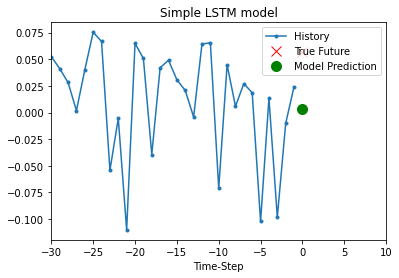

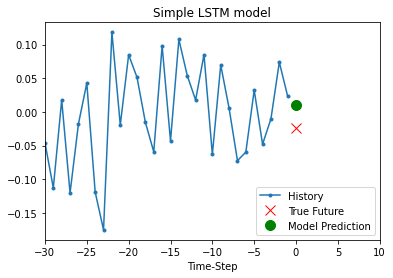

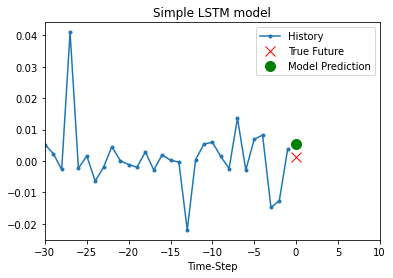

In [217]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()


In [218]:
asdf = test[:30].reshape(1, -1, 1)

In [219]:
simple_lstm_model.predict(asdf)

array([[0.00610963]], dtype=float32)

In [220]:
test[31]

0.0296095095104425